# Possible substrates and their potential
This script evaluates other carbon sources for the production of malonic acid in K. phaffii.  
  
This script is still in work and is quite chaotic to read, sorry! Im still thinkg of a way to wrap the finding in a nice fashin so its readable.

In [1]:
# Importing used packages and model
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd
model = read_sbml_model('../src/models/gen/iMT1026-v3.1.xml')
%run -i create_pathway.ipynb
# flux unit is mmol / [gDW h]

In [2]:
# path_selector legend
# 0 -> no additional reactions
#1 -> beta alanine pathway  
#2 -> transferase malonyl-CoA pathway  
#3 -> oxidoreuctive malonyl-CoA pathway
#4 -> lactate pathway  
#create_pathway(model,3)  # self-built function create_pathway(model, path_selector), that adds pathway
factor_growth = 0.5
beta_model = create_pathway(model.copy(),1)
trn_malonyl_model = create_pathway(model.copy(),2)
red_malonyl_model = create_pathway(model.copy(),3)
lactate_model = create_pathway(model.copy(),4)
models = [(beta_model,'Beta-Alanine'),(trn_malonyl_model,'Malonyl-CoA Transferase'),(red_malonyl_model,'Malonyl-CoA Oxidored'),(lactate_model,'Lactate')]

Added beta alanine pathway
Added trans malonyl-CoA pathway
Added red malonyl-CoA pathway
Added lactate pathway


## Evaluating for MA production

In [3]:
# Determining the implemented exchange reactions in the model
exchange_reactions =[]
for reaction in model.exchanges:
        metabolites = reaction.metabolites.keys()
        for ids in metabolites:
            if model.metabolites.get_by_id(str(ids)).formula == None:
                pass
            elif 'C' in model.metabolites.get_by_id(str(ids)).formula:
                exchange_reactions.append(reaction.id)
                break

In [4]:
# Helper function to count the C-Atoms within the metabolite to evaluate C-maol based results later
def count_C(pathway_model,metabolite):
    # counts the C in the metabolite formula -> returns the number formated as an float
    C_locator = pathway_model.metabolites.get_by_id(str(metabolite)).formula.find('C')+1
    H_locator = pathway_model.metabolites.get_by_id(str(metabolite)).formula.find('H')
    C_amount = pathway_model.metabolites.get_by_id(str(metabolite)).formula[C_locator:H_locator]
    if C_amount == '':
        C_amount = '1'
    elif 'O' in C_amount:
        C_amount = '1'
    return float(C_amount)

In [5]:
# Little complicated analysis for the producation rate of malonic acid for all the different possible substrates
# Divides the media flux by the C amount and then simulates
# Still contains two lines where not_poss gets written -> needed? delete?
factor_growth = 0
substrate_table = pd.DataFrame()
ex_subs = []
for pairing in models:
    pathway_model = pairing[0]
    poss_subs = dict()
    not_poss = []
    for sub in exchange_reactions:
        with pathway_model:
            # Calculating the amounts of C in substrate
            meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()
            for met in meta:
                C_amount = count_C(pathway_model,met)
            #set up medium
            medium = pathway_model.medium
            medium['Ex_glyc']= 0
            medium[sub]= 10/C_amount  # for Cmol based evaluation, in order to have a 100 C-mmol supply flux
            pathway_model.medium = medium
            # Adding constraint
            max_growth_sub = pathway_model.slim_optimize(error_value=0.)  # I could get rid of non growth subs already here before i simulate them again for the ma production adn then branch them (assumption that non growth media also leads to no ma production)
            constrained_growth = pathway_model.problem.Constraint(
                pathway_model.reactions.Ex_biomass.flux_expression,
                lb=max_growth_sub*factor_growth)
            pathway_model.add_cons_vars(constrained_growth)
            # simulate
            pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
            ma_prod_sub = pathway_model.slim_optimize(error_value=0.)
            # analyse
            if ma_prod_sub > 0:
                poss_subs[met.name] = round(ma_prod_sub, 2)
                ex_subs.append(sub)
            else:
                not_poss.append(sub)
    name = pairing[1]
    substrate_table[name] = pd.Series(poss_subs)

In [6]:
all_subs_formula = dict()
all_subs_id = dict()
for sub in exchange_reactions:
    meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()
    for met in meta:
        all_subs_formula[met.name] = pathway_model.metabolites.get_by_id(str(met)).formula
poss_subs_formula = dict()
for poss_meta in poss_subs:
    poss_subs_formula[poss_meta] = all_subs_formula[poss_meta]

substrate_table['Formula'] = pd.Series(poss_subs_formula)

In [7]:
# Sorting the data frame and retrieving the table 
#by=['Formula','Beta-Alanine', 'Beta-Alanine Cmol', 'Malonyl-CoA', 'Malonyl-CoA Cmol', 'Lactate', 'Lactate Cmol'],
substrate_table.sort_values(by=['Beta-Alanine','Lactate'],ascending=False,inplace=True)
substrate_table

,Beta-Alanine,Malonyl-CoA Transferase,Malonyl-CoA Oxidored,Lactate,Formula
Trehalose,3.33,3.33,3.33,3.33,C12H22O11
D-Glucose,3.33,3.33,3.33,3.33,C6H12O6
"1,3-beta-D-Glucan",3.33,3.33,3.33,3.33,(C6H10O5)n
Glycerol,3.33,3.33,3.33,3.33,C3H8O3
D-Sorbitol,3.33,3.33,3.33,3.33,C6H14O6
D-Mannitol,3.33,3.33,3.33,3.33,C6H14O6
D-Fructose,3.33,3.33,3.33,3.33,C6H12O6
D-Mannose,3.33,3.33,3.33,3.33,C6H12O6
Xylitol,3.33,3.33,3.33,3.33,C5H12O5
D-Xylose,3.33,3.33,3.33,3.27,C5H10O5


<AxesSubplot:title={'center':'MA production with different substrates'}, ylabel='C-mol based flux in mmol MA / (gDW*h)'>

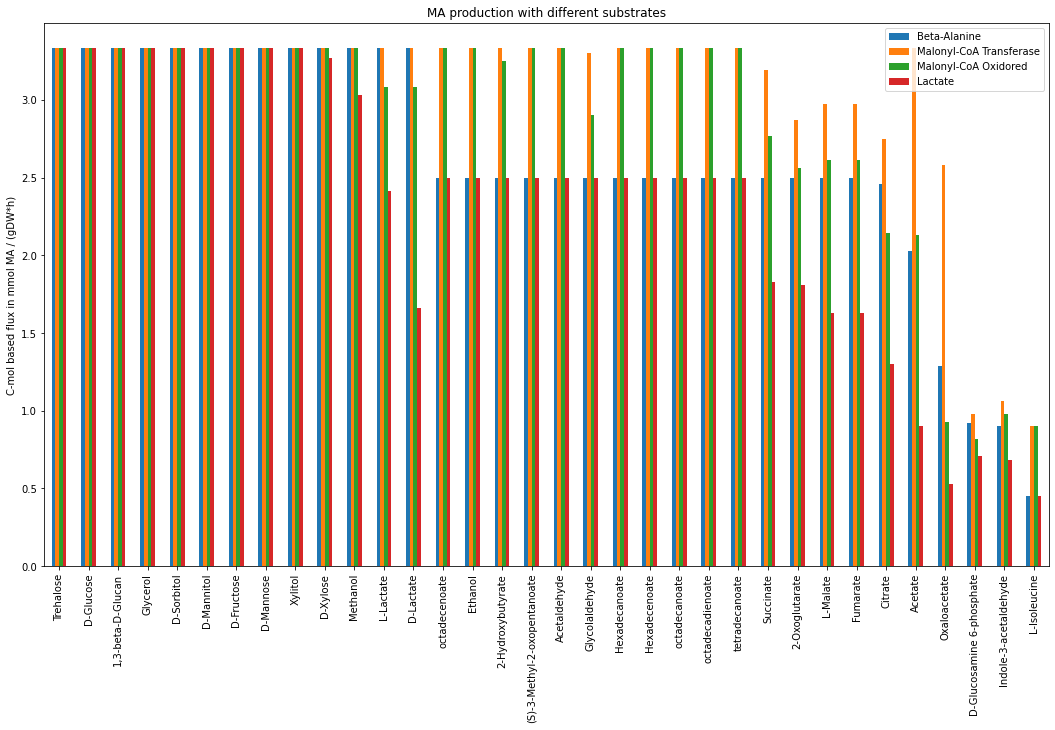

In [8]:
arguments = list(substrate_table.columns)
arguments = ['Beta-Alanine', 'Malonyl-CoA Transferase', 'Malonyl-CoA Oxidored', 'Lactate']
substrate_table.plot(y= arguments, kind='bar', figsize=(18,10), ylabel = 'C-mol based flux in mmol MA / (gDW*h)', title = 'MA production with different substrates')

## Evaluating for biomass growth 

In [9]:
# Little complicated analysis for the producation rate of malonic acid for all the different possible substrates
# Divides the media flux by the C amount and then simulates
# Still contains two lines where not_poss gets written -> delete?
factor_growth = 1
substrate_table_bm = pd.DataFrame()
for pairing in models:
    pathway_model = pairing[0]
    poss_subs = dict()
    not_poss = []
    for sub in ex_subs:
        with pathway_model:
            # Calculating the amounts of C in substrate
            meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()
            for met in meta:
                C_amount = count_C(pathway_model,met)
            #set up medium
            medium = pathway_model.medium
            medium['Ex_glyc']= 0
            medium[sub]= 10/C_amount  # for Cmol based evaluation
            pathway_model.medium = medium
            # Adding constraint
            max_growth_sub = pathway_model.slim_optimize(error_value=0.)  # I could get rid of non growth subs already here before i simulate them again for the ma production adn then branch them (assumption that non growth media also leads to no ma production)
            constrained_growth = pathway_model.problem.Constraint(
                pathway_model.reactions.Ex_biomass.flux_expression,
                lb=max_growth_sub*factor_growth)
            pathway_model.add_cons_vars(constrained_growth)
            # simulate
            pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
            solution = pathway_model.optimize()
            biomass_prod = solution.fluxes.Ex_biomass
            # analyse
            if biomass_prod > 0:
                poss_subs[met.name] = round(biomass_prod, 4)
            else:
                not_poss.append(sub)
    name = pairing[1]
    substrate_table_bm[name] = pd.Series(poss_subs)

In [10]:
# Sorting the data frame and retrieving the table 
#by=['Formula','Beta-Alanine', 'Beta-Alanine Cmol', 'Malonyl-CoA', 'Malonyl-CoA Cmol', 'Lactate', 'Lactate Cmol'],
substrate_table_bm.sort_values(by=['Beta-Alanine','Lactate'],ascending=False,inplace=True)
substrate_table_bm

,Beta-Alanine,Malonyl-CoA Transferase,Malonyl-CoA Oxidored,Lactate
Ethanol,0.2206,0.2206,0.2206,0.2206
Glycerol,0.2170,0.2170,0.2170,0.2170
Xylitol,0.2058,0.2058,0.2058,0.2058
D-Sorbitol,0.2027,0.2027,0.2027,0.2027
D-Mannitol,0.2027,0.2027,0.2027,0.2027
octadecanoate,0.2027,0.2027,0.2027,0.2027
Hexadecanoate,0.2018,0.2018,0.2018,0.2018
tetradecanoate,0.2005,0.2005,0.2005,0.2005
octadecenoate,0.1986,0.1986,0.1986,0.1986
octadecadienoate,0.1982,0.1982,0.1982,0.1982


<AxesSubplot:title={'center':'Biomass growth with different substrates'}, ylabel='Cmol based flux in mmol bm / (gDW*h)'>

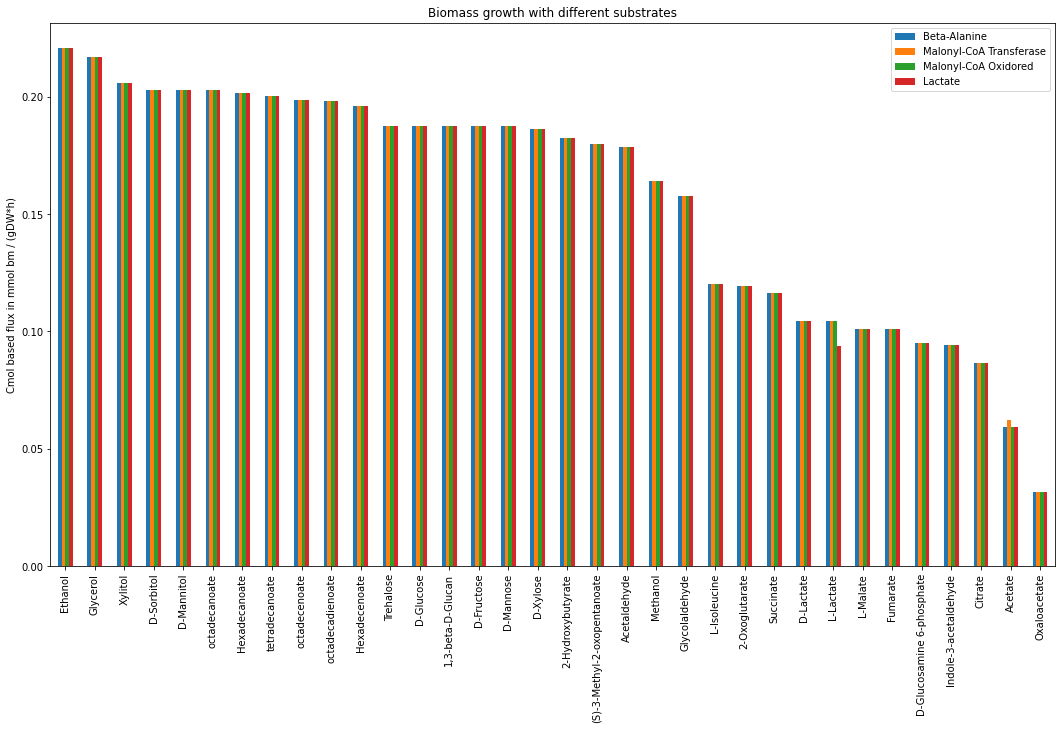

In [11]:
arguments = list(substrate_table_bm.columns)
arguments = ['Beta-Alanine', 'Malonyl-CoA Transferase', 'Malonyl-CoA Oxidored', 'Lactate']
substrate_table_bm.plot(y= arguments, kind='bar', figsize=(18,10), ylabel = 'Cmol based flux in mmol bm / (gDW*h)', title = 'Biomass growth with different substrates')

## Evaluating for constrained gowth at 50%

In [13]:
# Little complicated analysis for the producation rate of malonic acid for all the different possible substrates
# Divides the media flux by the C amount and then simulates
# Still contains two lines where not_poss gets written -> needed? delete?
factor_growth = 0.5
substrate_table = pd.DataFrame()
ex_subs = []
for pairing in models:
    pathway_model = pairing[0]
    poss_subs = dict()
    not_poss = []
    for sub in exchange_reactions:
        with pathway_model:
            # Calculating the amounts of C in substrate
            meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()
            for met in meta:
                C_amount = count_C(pathway_model,met)
            #set up medium
            medium = pathway_model.medium
            medium['Ex_glyc']= 0
            medium[sub]= 10/C_amount  # for Cmol based evaluation, in order to have a 100 C-mmol supply flux
            pathway_model.medium = medium
            # Adding constraint
            max_growth_sub = pathway_model.slim_optimize(error_value=0.)  # I could get rid of non growth subs already here before i simulate them again for the ma production adn then branch them (assumption that non growth media also leads to no ma production)
            constrained_growth = pathway_model.problem.Constraint(
                pathway_model.reactions.Ex_biomass.flux_expression,
                lb=max_growth_sub*factor_growth)
            pathway_model.add_cons_vars(constrained_growth)
            # simulate
            pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
            ma_prod_sub = pathway_model.slim_optimize(error_value=0.)
            # analyse
            if ma_prod_sub > 0:
                poss_subs[met.name] = round(ma_prod_sub, 2)
                ex_subs.append(sub)
            else:
                not_poss.append(sub)
    name = pairing[1]
    substrate_table[name] = pd.Series(poss_subs)

In [14]:
all_subs_formula = dict()
all_subs_id = dict()
for sub in exchange_reactions:
    meta = pathway_model.reactions.get_by_id(str(sub)).metabolites.keys()
    for met in meta:
        all_subs_formula[met.name] = pathway_model.metabolites.get_by_id(str(met)).formula
poss_subs_formula = dict()
for poss_meta in poss_subs:
    poss_subs_formula[poss_meta] = all_subs_formula[poss_meta]

substrate_table['Formula'] = pd.Series(poss_subs_formula)

In [15]:
# Sorting the data frame and retrieving the table 
#by=['Formula','Beta-Alanine', 'Beta-Alanine Cmol', 'Malonyl-CoA', 'Malonyl-CoA Cmol', 'Lactate', 'Lactate Cmol'],
substrate_table.sort_values(by=['Beta-Alanine','Lactate'],ascending=False,inplace=True)
substrate_table

,Beta-Alanine,Malonyl-CoA Transferase,Malonyl-CoA Oxidored,Lactate,Formula
Trehalose,2.21,2.24,1.96,1.78,C12H22O11
D-Glucose,2.21,2.24,1.96,1.78,C6H12O6
"1,3-beta-D-Glucan",2.21,2.24,1.96,1.78,(C6H10O5)n
D-Fructose,2.21,2.24,1.96,1.78,C6H12O6
D-Mannose,2.21,2.24,1.96,1.78,C6H12O6
D-Sorbitol,2.15,2.15,2.06,1.86,C6H14O6
D-Mannitol,2.15,2.15,2.06,1.86,C6H14O6
Xylitol,2.13,2.13,2.08,1.88,C5H12O5
D-Xylose,2.12,2.24,1.88,1.69,C5H10O5
Glycerol,2.07,2.07,2.07,2.06,C3H8O3


<AxesSubplot:title={'center':'MA production with different substrates at 50% growth'}, ylabel='C-mol based flux in mmol MA / (gDW*h)'>

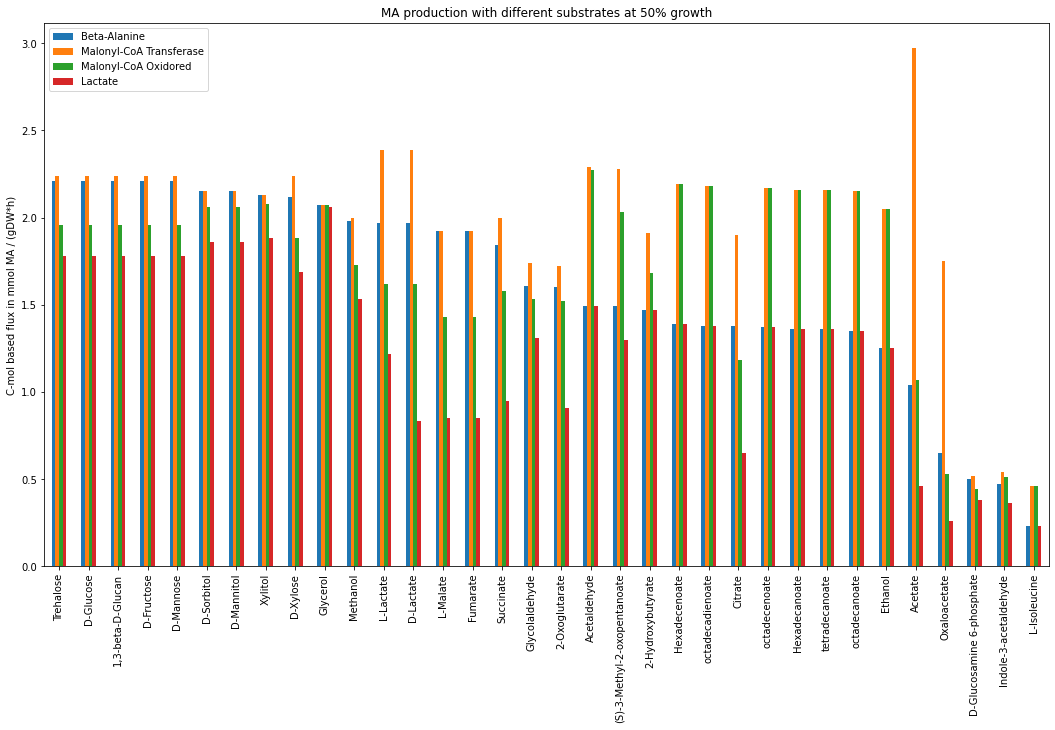

In [17]:
arguments = list(substrate_table.columns)
arguments = ['Beta-Alanine', 'Malonyl-CoA Transferase', 'Malonyl-CoA Oxidored', 'Lactate']
substrate_table.plot(y= arguments, kind='bar', figsize=(18,10), ylabel = 'C-mol based flux in mmol MA / (gDW*h)', title = 'MA production with different substrates at 50% growth')